This notebook is an example of "Flow Matching for Generative Modeling" https://arxiv.org/abs/2210.02747

    Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le
    Flow Matching for Generative Modeling
    2022

We will create a toy dataset and then try to train a model that will learn to generate samples such as from this dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
from torch import nn
from tqdm import tqdm
from zuko.utils import odeint

plt.rcParams["animation.html"] = "jshtml"

torch.cuda.set_device(3)

# Data

First, let's create the fake dataset. It will have only two features so that it can be easily visualized on a plane.

In [2]:
def create_dataset(size: int = 100_000):
    complex_points = torch.polar(torch.tensor(1.0), torch.rand(size) * 2 * torch.pi)
    X = torch.stack((complex_points.real, complex_points.imag)).T
    upper = complex_points.imag > 0
    left = complex_points.real < 0
    X[upper, 1] = 0.5
    X[upper & left, 0] = -0.5
    X[upper & ~left, 0] = 0.5
    noise = torch.zeros_like(X)
    noise[upper] = torch.randn_like(noise[upper]) * 0.10
    noise[~upper] = torch.randn_like(noise[~upper]) * 0.05
    X += noise
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return X + noise
    

dataset = create_dataset()
noise = torch.randn_like(dataset)

dataset.shape

torch.Size([100000, 2])

Now let's plot the dataset on a 2D histogram, where intense colors mean many samples.

Let's also plot random noise. It will be important for the method - our model will learn how to transform this random distribution into our target distribution - the dataset.

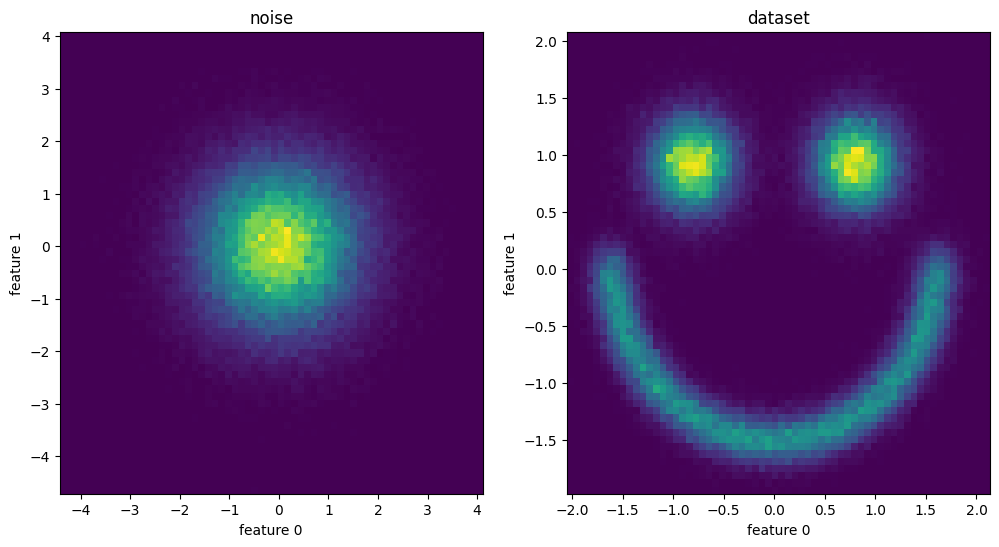

In [3]:
def plot_dataset(X, bins, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.hist2d(*X.T, bins=bins)
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set(**kwargs)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_dataset(noise, bins=64, ax=axs[0], title='noise')
plot_dataset(dataset, bins=64, ax=axs[1], title='dataset')

# Flow

Now the most important concept - the flow.

Let's consider a process of data transformation with time flowing from 0 to 1.

At 0, we start with the random noise. At 1, we hope to arrive at the target distrubtion - our dataset.

For every

 - time value between 0 and 1
 - point in our feature space

the flow model specifies a direction in the feature space.

Below we define an ExampleFlow.

In [4]:
class FlowModel(nn.Module):

    def forward(self, X, time):
        raise NotImplementedError()


class ExampleFlow(FlowModel):

    def forward(self, X, time):
        result = torch.zeros_like(X)
        result[:, 0] = -X[:, 0] * time
        result[:, 1] = X[:, 1] * (1 - time)
        return result

ExampleFlow()(torch.tensor([[.2, .4]]), time=torch.tensor([.6]))

tensor([[-0.1200,  0.1600]])

As it turns out, according to our ExampleFlow, at time step 0.6 and at data point where the features are .2 and .4, the probability density flows towards -0.12 and 0.16 in these dimensions respectively.

Let's visualize these directions across time and space:

In [5]:
@torch.no_grad()
def plot_flow_at_time(flow_model, time, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    points = torch.linspace(-1, 1, 10)
    flow_input = torch.cartesian_prod(points, points)
    flow_output = flow_model(flow_input, time=torch.full(flow_input.shape[:1], time))
    ax.quiver(
        torch.stack(torch.chunk(flow_input[:, 0], len(points))).numpy(),
        torch.stack(torch.chunk(flow_input[:, 1], len(points))).numpy(),
        torch.stack(torch.chunk(flow_output[:, 0], len(points))).numpy(),
        torch.stack(torch.chunk(flow_output[:, 1], len(points))).numpy(),
        scale=len(points),
    )
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set(**kwargs)


def animate_flow(flow_model, frames: int = 20):

    def plot_frame(time):
        plt.cla()
        plot_flow_at_time(flow_model, time=time, title=f'flow at time={time:.2f}')
    
    fig = plt.figure(figsize=(8, 8))
    animation = FuncAnimation(fig, plot_frame, frames=np.linspace(0, 1, frames))
    html = HTML(animation.to_html5_video())
    plt.close()
    return html
    
animate_flow(ExampleFlow())

# Running a flow

Once we have a flow and a data point (our a set of such points) we can "follow the flow", which also can be visualized - let's see how our random noise is transformed by the ExampleFlow as time goes from 0 to 1.

In [6]:
@torch.no_grad()
def run_flow(flow_model, x_0, t_0, t_1, device='cpu'):
    def f(t: float, x):
        return flow_model(x, time=torch.full(x.shape[:1], t, device=device))

    return odeint(f, x_0, t_0, t_1, phi=flow_model.parameters())


def animate_flow_run(flow_model, X, frames=20, device='cpu'):
    bins = [
        np.linspace(X[:, 0].min().cpu(), X[:, 0].max().cpu(), 128),
        np.linspace(X[:, 1].min().cpu(), X[:, 1].max().cpu(), 128),
    ]

    def plot_frame(time):
        plt.cla()
        plot_dataset(run_flow(flow_model, X, 0, time, device=device).cpu(), bins=bins, title=f'distribution at time {time:.2f}')
    
    fig = plt.figure(figsize=(8, 8))
    animation = FuncAnimation(fig, plot_frame, frames=np.linspace(0, 1, frames))
    html = HTML(animation.to_html5_video())
    plt.close()
    return html


animate_flow_run(ExampleFlow(), noise)

# Trainable flow model

Our ExampleFlow had no trainable parameters and obviously has not produced the target distrubion at time 1.

Let's define a neural network with trainable parameters that we can hope can be trained to do the job.

In [7]:
class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        emb = self.freqs * t[..., None]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class FlowNeuralNetwork(FlowModel):

    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features)


    def forward(self, X, time):
        X = torch.cat([X, self.time_embedding(time)], axis=1)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

We can visualize what it does before training, with the parameters initialized randomly.

In [8]:
model = FlowNeuralNetwork(n_features=2)
animate_flow(model)

In [9]:
animate_flow_run(model.cuda(), noise.cuda(), device='cuda')

# Training

OK now let's actually train it.

The conditional flow matching loss works as follows:
 - we are given some data points 
 - for every data point we randomly choose a time value t between 0 and 1
 - we calculate x_t, which is a linear interpolation between gaussian noise and the data points
 - we define the optimal flow as pointing from the sampled noise straight at the corresponding data points
 - the loss is the mean square difference between the optimal flow and what the flow model outputs

In [10]:
def conditional_flow_matching_loss(flow_model, x):
    sigma_min = 1e-4
    t = torch.rand(x.shape[0], device=x.device)
    noise = torch.randn_like(x)

    x_t = (1 - (1 - sigma_min) * t[:, None]) * noise + t[:, None] * x
    optimal_flow = x - (1 - sigma_min) * noise
    predicted_flow = flow_model(x_t, time=t)

    return (predicted_flow - optimal_flow).square().mean()

model.cuda().train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in tqdm(range(10_000)):
    model.zero_grad()
    loss = conditional_flow_matching_loss(model, create_dataset(10000).cuda())
    loss.backward()
    optimizer.step()

model = model.eval()
pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:48<00:00, 207.31it/s]


Now let's visualize the model after training

In [11]:
animate_flow(model.cpu())

In [12]:
animate_flow_run(model.cuda(), noise.cuda(), device='cuda')

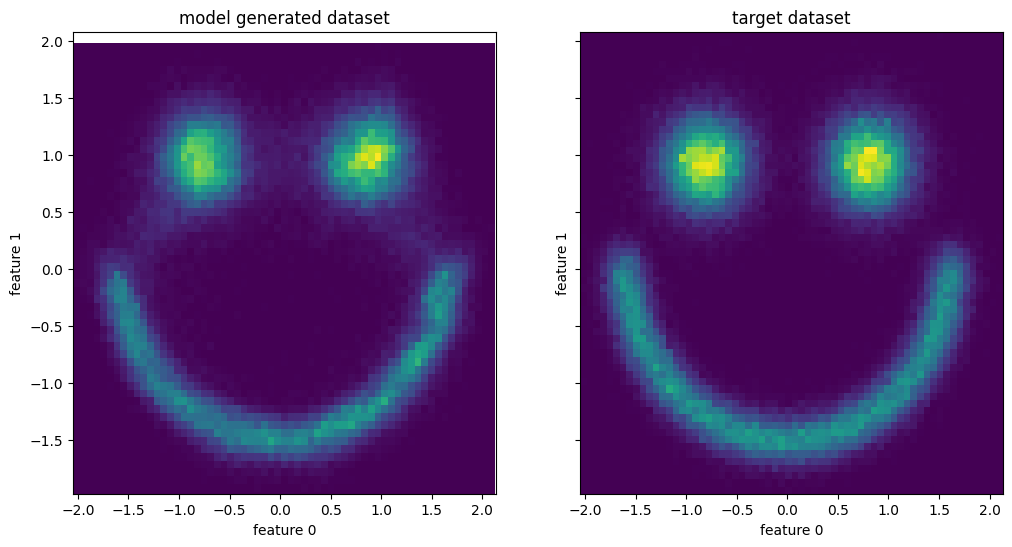

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
plot_dataset(run_flow(model.cuda(), noise.cuda(), 0, 1, device='cuda').cpu(), bins=64, ax=axs[0], title='model generated dataset')
plot_dataset(dataset, bins=64, ax=axs[1], title='target dataset')

Looks good!